In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os

In [2]:
# Sobel X,Y Filter Generator Function
def generate_sobel_filters(n):
    if n % 2 == 0:
        raise ValueError("The size of the filter 'n' must be odd")

    sobel_x = np.zeros((n,n),dtype="float64")
    sobel_y = np.zeros((n,n),dtype="float64")

    mid = n//2

    for i in range(n):
        for j in range(n):
            sobel_x[i,j] = (mid - i)*(2 - (mid!=j))
            sobel_y[i,j] = (mid - j)*(2 - (mid!=i))

    return sobel_x,sobel_y

# Gaussian Filter Generator Function
def generate_gaussian_filter(n,sigma):
    if n % 2 == 0:
        raise ValueError("The size of the kernel 'n' must be odd")

    kernel = np.zeros((n, n))

    mid = n // 2

    for i in range(n):
        for j in range(n):
            x = i - mid
            y = j - mid
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = kernel / np.sum(kernel)
    return kernel

# Convolution Function
def convolve(img, kernel):
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("The dimensions of kernel must be both odd")

    img_height,img_width = img.shape[0],img.shape[1]

    pad_height,pad_width = kernel.shape[0]//2 , kernel.shape[0]//2

    pad = ((pad_height, pad_height), (pad_height, pad_width))

    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)

    # Convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255)
    return g

In [6]:
def harris(img, threshold=0.6, window_size=3,sobel_filter_size=3,k=0.12):

    img_gray = img.copy()
    img_gray = np.array(img_gray.convert('L'))

    sobel_filter_x , sobel_filter_y = generate_sobel_filters(sobel_filter_size)

    gaussian_filter = generate_gaussian_filter(window_size,1)

    Ix = convolve(img_gray, sobel_filter_x) # convolving with sobel filter on X-axis
    Iy = convolve(img_gray, sobel_filter_y) # convolving with sobel filter on Y-axis

    # square of derivatives
    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)

    IxIy = Ix*Iy #cross filtering

    g_Ix2 = convolve(Ix2, gaussian_filter)
    g_Iy2 = convolve(Iy2, gaussian_filter)
    g_IxIy = convolve(IxIy, gaussian_filter)

    # Harris Function
    # R(harris) = det - k*(trace**2)
    harris = g_Ix2*g_Iy2 - np.square(g_IxIy) - k*np.square(g_Ix2 + g_Iy2)

    # Normalizing output image values
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold (nonmax supression line)
    loc = np.where(harris >= threshold)

    output_img = img.copy()
    output_img = np.array(output_img.convert('RGB'))

    # drawing filtered points on the output image
    for pt in zip(*loc[::-1]): cv2.circle(output_img, pt, 5, (255, 0, 0), -1)

    return output_img

In [7]:
def opencv_harris(img,maxCorners,threshold,k):
    img_gray = img.copy()
    img_gray = np.array(img_gray.convert('L'))
    corners = cv2.goodFeaturesToTrack(img_gray, maxCorners,threshold,10,useHarrisDetector=True,k=k)
    corners = np.int0(corners)

    output_img = img.copy()
    output_img = np.array(output_img.convert('RGB'))

    for i in corners:
        x, y = i.ravel()
        cv2.circle(output_img, (x,y), 5, (255, 0, 0), -1)
    
    return output_img

In [4]:
path = './Question 1'
list_images = os.listdir(path)
print(list_images)

['1.gif', '10.jpg', '11.jpg', '2.jpeg', '3.png', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpeg']


C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_24676\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


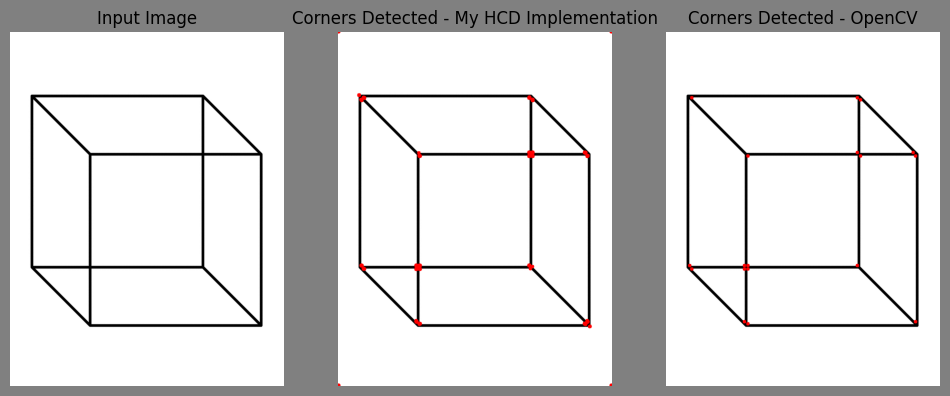

In [8]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[0])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


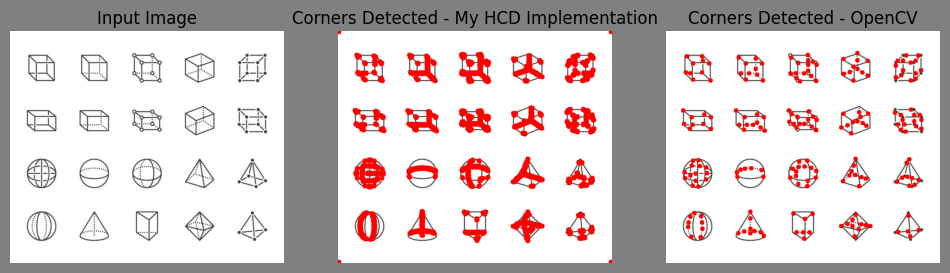

In [39]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[1])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,500,0.1,k=0.02)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


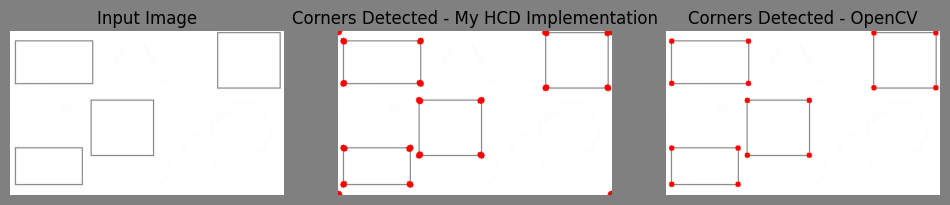

In [33]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[2])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_15488\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


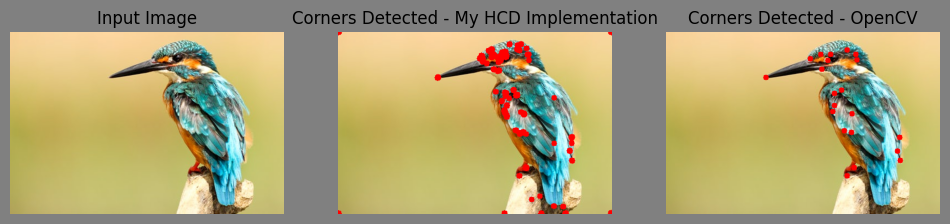

In [8]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[3])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,200,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


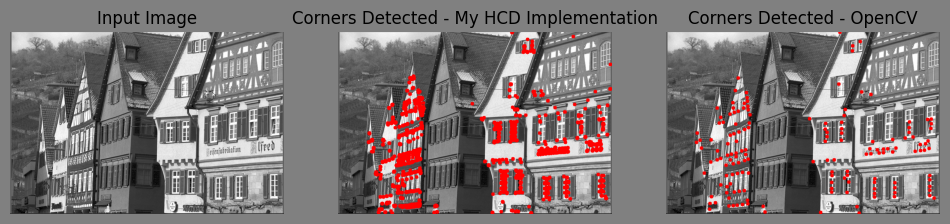

In [38]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[4])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,500,0.2,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


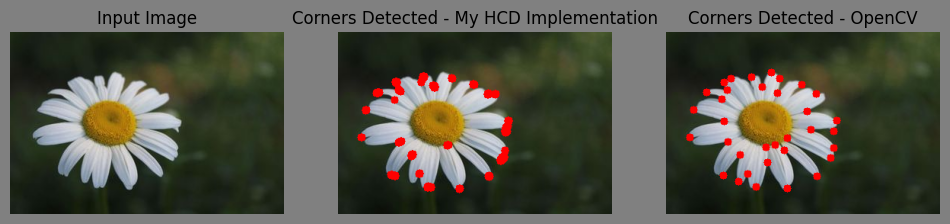

In [44]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[5])
result_img = harris(img,threshold=0.5,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,500,0.05,k=0.01)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


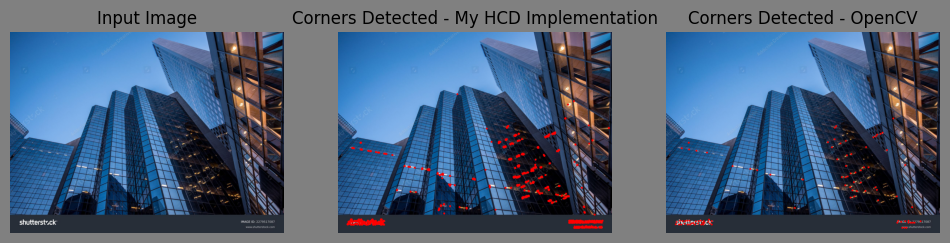

In [46]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[6])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_15488\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


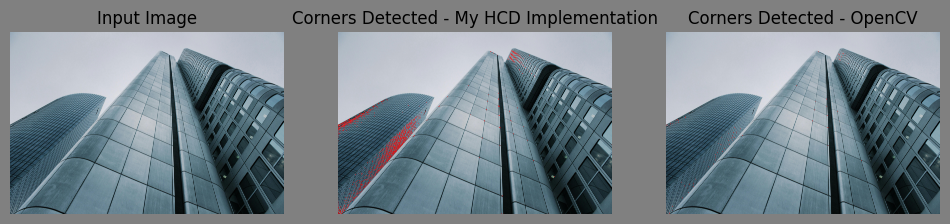

In [9]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[7])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


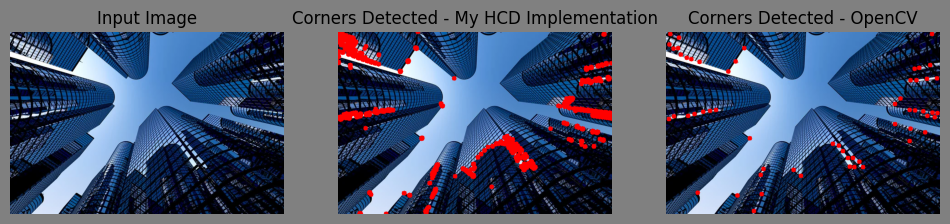

In [47]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[8])
result_img = harris(img,threshold=0.3,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()

C:\Users\Anadi Sharma\AppData\Local\Temp\ipykernel_25584\2762488880.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


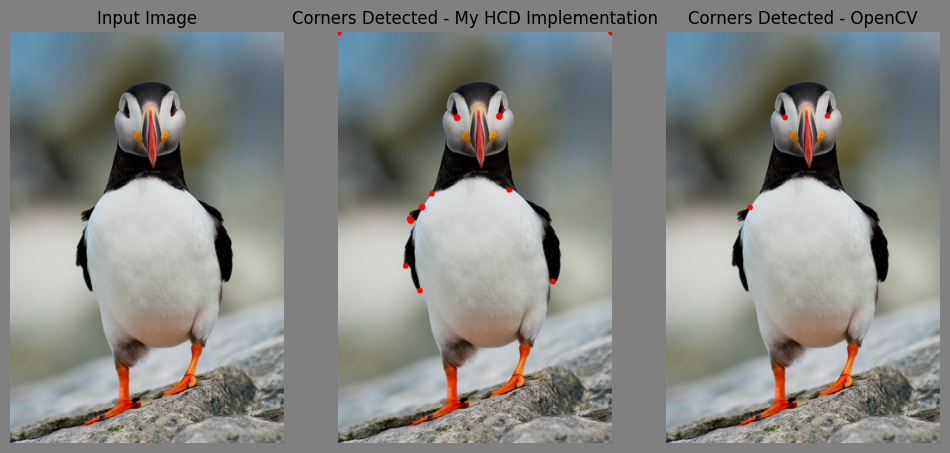

In [49]:
fig = plt.figure(figsize=(12,16),facecolor='gray')

img = Image.open(path+'/'+list_images[9])
result_img = harris(img,threshold=0.5,window_size=5,sobel_filter_size=3,k=0.04)
opencv_result_img = opencv_harris(img,100,0.3,k=0.04)

fig.add_subplot(1,3,1)
plt.imshow(np.array(img.convert('RGB')))
plt.axis('off')
plt.title('Input Image')

fig.add_subplot(1,3,2)
plt.imshow(result_img)
plt.axis('off')
plt.title('Corners Detected - My HCD Implementation')

fig.add_subplot(1,3,3)
plt.imshow(opencv_result_img)
plt.axis('off')
plt.title('Corners Detected - OpenCV')


plt.show()